# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 50

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            aspect_list,
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def least_confidence_sampling(filename, aspect_model, sentiment_model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, threshold, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool, 
        [['neut' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            preds = torch.sigmoid(outputs.logits)

        for i in range(len(preds)):
            aspect_outputs[batch['ori_indices'][i].item()] = np.max(preds[i].cpu().numpy())
            
            for j in range(len(preds[i])):
                if int(preds[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])
    
    sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
    sentiment_loader = torch.utils.data.DataLoader(
        sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    # Pass through sentiment analysis model
    for batch in sentiment_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        with torch.no_grad():
            outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            preds = torch.sigmoid(outputs.logits)

        for i in range(len(preds)):
            ori_index = batch['ori_indices'][i].item()
            if ori_index in sentiment_outputs.keys():
                max_pred = np.max(preds[i].cpu().numpy())
                sentiment_outputs[ori_index] = max_pred if max_pred > sentiment_outputs[ori_index] else sentiment_outputs[ori_index]
            else:
                sentiment_outputs[ori_index] = np.max(preds[i].cpu().numpy())

    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))
    
        # accelerator.print(aspect_outputs)
        for key, val in sentiment_outputs.items():
            aspect_outputs[key] = 1 - ((val + aspect_outputs[key]) / 2)
    
        # accelerator.print(aspect_outputs)
        uncertainties = np.array(list(aspect_outputs.values()))
        sorted_unc = np.argsort(uncertainties)
        sorted_unc = sorted_unc[::-1]

        percentile = np.percentile(uncertainties, threshold * 100)
        items_greater_than_average = uncertainties[uncertainties >= percentile]
        num_of_candidates = len(items_greater_than_average)
        
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil((1-threshold)*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'ac': [y_train[i][0] for i in temp],
                'air_panas': [y_train[i][1] for i in temp],
                'bau': [y_train[i][2] for i in temp],
                'general': [y_train[i][3] for i in temp],
                'kebersihan': [y_train[i][4] for i in temp],
                'linen': [y_train[i][5] for i in temp],
                'service': [y_train[i][6] for i in temp],
                'sunrise_meal': [y_train[i][7] for i in temp],
                'tv': [y_train[i][8] for i in temp],
                'wifi': [y_train[i][9] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", percentile)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
def active_learning(seed, i, threshold, init_size):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    filename = f'hoasa-lc-init-{init_size}'

    set_seed(seed)
    
    print("===============================================")
    print("Init size: {}".format(init_size))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed,
            filename
        )
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model-{percentage}')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            filename,
            aspect_model, 
            sentiment_model, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i,
            threshold
        )
        notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed,
        filename
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results-{int(threshold * 100)}.csv', index=False)

Init size: 1
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7629, Accuracy: 0.4733, F1 Micro: 0.5873, F1 Macro: 0.491
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.7254, Accuracy: 0.5719, F1 Micro: 0.6993, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6779, Accuracy: 0.6304, F1 Micro: 0.7608, F1 Macro: 0.6848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.616, Accuracy: 0.6764, F1 Micro: 0.8005, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5873, Accuracy: 0.7193, F1 Micro: 0.8328, F1 Macro: 0.8117
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5466, Accuracy: 0.7545, F1 Micro: 0.8574, F1 Macro: 0.8462
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.5374, Accuracy: 0.7812, F1 Micro: 0.8753, F1 Macro: 0.868
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4948, Accuracy: 0.7958, F1 Micro: 0.8848, F1 Macro: 0.8769
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7093, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6098, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5463, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4848, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4943, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4027, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3762, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4164, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6367, Accuracy: 0.7998, F1 Micro: 0.8887, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4863, Accuracy: 0.8043, F1 Micro: 0.8905, F1 Macro: 0.8847
Epoch 3/10, Train Loss: 0.4663, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4599, Accuracy: 0.8104, F1 Micro: 0.8934, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4461, Accuracy: 0.8177, F1 Micro: 0.897, F1 Macro: 0.8908
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4099, Accuracy: 0.8418, F1 Micro: 0.9088, F1 Macro: 0.9019
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3673, Accuracy: 0.8623, F1 Micro: 0.919, F1 Macro: 0.9115
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3374, Accuracy: 0.8753, F1 Micro: 0.926, F1 Macro: 0.9188
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3042, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5373, Accuracy: 0.6692, F1 Micro: 0.6692, F1 Macro: 0.4009
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4037, Accuracy: 0.6692, F1 Micro: 0.6692, F1 Macro: 0.4009
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4117, Accuracy: 0.6705, F1 Micro: 0.6705, F1 Macro: 0.405
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3052, Accuracy: 0.7782, F1 Micro: 0.7782, F1 Macro: 0.7358
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2613, Accuracy: 0.7795, F1 Micro: 0.7795, F1 Macro: 0.7344
Epoch 6/10, Train Loss: 0.2235, Accuracy: 0.7731, F1 Micro: 0.7731, F1 Macro: 0.7109
Epoch 7/10, Train Loss: 0.1393, Accuracy: 0.7731, F1 Micro: 0.7731, F1 Macro: 0.7236
Epoch 8/10, Train Loss: 0.1556, Accuracy: 0.7744, F1 Micro: 0.7744, F1 Macro: 0.7058
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1428, Accuracy: 0.782, F1 Micro: 0.782, F1 Macro: 0.7498
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.567, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4559, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4433, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4139, Accuracy: 0.8372, F1 Micro: 0.9072, F1 Macro: 0.9022
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3566, Accuracy: 0.879, F1 Micro: 0.9287, F1 Macro: 0.9229
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2881, Accuracy: 0.9, F1 Micro: 0.94, F1 Macro: 0.9344
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2412, Accuracy: 0.9097, F1 Micro: 0.9453, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2154, Accuracy: 0.9227, F1 Micro: 0.9529, F1 Macro: 0.9482
Higher F1 achieved, saving model
Epoch 9/10, Trai

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5146, Accuracy: 0.7451, F1 Micro: 0.7451, F1 Macro: 0.427
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3824, Accuracy: 0.8209, F1 Micro: 0.8209, F1 Macro: 0.7136
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2558, Accuracy: 0.8549, F1 Micro: 0.8549, F1 Macro: 0.7724
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1829, Accuracy: 0.8604, F1 Micro: 0.8604, F1 Macro: 0.8051
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1335, Accuracy: 0.8791, F1 Micro: 0.8791, F1 Macro: 0.8156
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.8659, F1 Micro: 0.8659, F1 Macro: 0.8024
Epoch 7/10, Train Loss: 0.0919, Accuracy: 0.878, F1 Micro: 0.878, F1 Macro: 0.8244
Epoch 8/10, Train Loss: 0.0851, Accuracy: 0.8659, F1 Micro: 0.8659, F1 Macro: 0.8194
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.8813, F1 Micro: 0.8813, F1 Macro: 0.8306
Epoch 10/10, Train Loss: 0.0511, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5404, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4415, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4187, Accuracy: 0.8373, F1 Micro: 0.9073, F1 Macro: 0.9022
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3497, Accuracy: 0.8915, F1 Micro: 0.9356, F1 Macro: 0.9305
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2891, Accuracy: 0.9142, F1 Micro: 0.9482, F1 Macro: 0.9436
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2432, Accuracy: 0.9283, F1 Micro: 0.9565, F1 Macro: 0.9533
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2036, Accuracy: 0.9354, F1 Micro: 0.9606, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1799, Accuracy: 0.9411, F1 Micro: 0.9639, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4727, Accuracy: 0.7962, F1 Micro: 0.7962, F1 Macro: 0.638
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3009, Accuracy: 0.8479, F1 Micro: 0.8479, F1 Macro: 0.7996
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2304, Accuracy: 0.8617, F1 Micro: 0.8617, F1 Macro: 0.7972
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1861, Accuracy: 0.8701, F1 Micro: 0.8701, F1 Macro: 0.8165
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.8786, F1 Micro: 0.8786, F1 Macro: 0.829
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.8796, F1 Micro: 0.8796, F1 Macro: 0.8207
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1168, Accuracy: 0.8828, F1 Micro: 0.8828, F1 Macro: 0.8269
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.8891, F1 Micro: 0.8891, F1 Macro: 0.8413
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5346, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4531, Accuracy: 0.8075, F1 Micro: 0.8927, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3804, Accuracy: 0.8934, F1 Micro: 0.9368, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3053, Accuracy: 0.9212, F1 Micro: 0.9522, F1 Macro: 0.9476
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2462, Accuracy: 0.9361, F1 Micro: 0.9611, F1 Macro: 0.9584
Epoch 6/10, Train Loss: 0.2012, Accuracy: 0.9351, F1 Micro: 0.9606, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1787, Accuracy: 0.947, F1 Micro: 0.9675, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1538, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.134, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4768, Accuracy: 0.8504, F1 Micro: 0.8504, F1 Macro: 0.805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2895, Accuracy: 0.8625, F1 Micro: 0.8625, F1 Macro: 0.7999
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2508, Accuracy: 0.8766, F1 Micro: 0.8766, F1 Macro: 0.8354
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1991, Accuracy: 0.8928, F1 Micro: 0.8928, F1 Macro: 0.8475
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8755
Epoch 7/10, Train Loss: 0.1133, Accuracy: 0.8847, F1 Micro: 0.8847, F1 Macro: 0.8323
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8766
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5345, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4443, Accuracy: 0.8439, F1 Micro: 0.91, F1 Macro: 0.9035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3509, Accuracy: 0.9047, F1 Micro: 0.943, F1 Macro: 0.9386
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2645, Accuracy: 0.93, F1 Micro: 0.9573, F1 Macro: 0.9535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2196, Accuracy: 0.9363, F1 Micro: 0.9613, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1837, Accuracy: 0.9418, F1 Micro: 0.9645, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1636, Accuracy: 0.949, F1 Micro: 0.9687, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1422, Accuracy: 0.9509, F1 Micro: 0.9698, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5045, Accuracy: 0.8283, F1 Micro: 0.8283, F1 Macro: 0.7727
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3233, Accuracy: 0.8565, F1 Micro: 0.8565, F1 Macro: 0.8232
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.224, Accuracy: 0.8817, F1 Micro: 0.8817, F1 Macro: 0.8458
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.8788, F1 Micro: 0.8788, F1 Macro: 0.8334
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.8894, F1 Micro: 0.8894, F1 Macro: 0.8499
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1235, Accuracy: 0.8982, F1 Micro: 0.8982, F1 Macro: 0.8658
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0656, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8741
Epoch 8/10, Train Loss: 0.0335, Accuracy: 0.8817, F1 Micro: 0.8817, F1 Macro: 0.8362
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.8982, F1 Micro: 0.8982, F1 Macro: 0.8665
Epoch 10/10, Train Loss: 0.0431, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5226, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4314, Accuracy: 0.8696, F1 Micro: 0.9239, F1 Macro: 0.9188
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3254, Accuracy: 0.9146, F1 Micro: 0.9488, F1 Macro: 0.9444
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.246, Accuracy: 0.9344, F1 Micro: 0.9602, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2015, Accuracy: 0.9457, F1 Micro: 0.9667, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1729, Accuracy: 0.949, F1 Micro: 0.9687, F1 Macro: 0.9663
Epoch 7/10, Train Loss: 0.155, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.13, Accuracy: 0.9523, F1 Micro: 0.9705, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1148, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4483, Accuracy: 0.8607, F1 Micro: 0.8607, F1 Macro: 0.8121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2804, Accuracy: 0.881, F1 Micro: 0.881, F1 Macro: 0.841
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.8975, F1 Micro: 0.8975, F1 Macro: 0.8662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.876
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.8965, F1 Micro: 0.8965, F1 Macro: 0.8595
Epoch 6/10, Train Loss: 0.0964, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.872
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8827
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8759
Epoch 10/10, Train Loss: 0.0422, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5196, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4154, Accuracy: 0.8913, F1 Micro: 0.9356, F1 Macro: 0.9305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3043, Accuracy: 0.9252, F1 Micro: 0.9543, F1 Macro: 0.9498
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2394, Accuracy: 0.9385, F1 Micro: 0.9626, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1949, Accuracy: 0.9446, F1 Micro: 0.9662, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1657, Accuracy: 0.949, F1 Micro: 0.9687, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.14, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.118, Accuracy: 0.9557, F1 Micro: 0.9727, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4255, Accuracy: 0.8408, F1 Micro: 0.8408, F1 Macro: 0.809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2766, Accuracy: 0.868, F1 Micro: 0.868, F1 Macro: 0.8311
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.216, Accuracy: 0.8886, F1 Micro: 0.8886, F1 Macro: 0.8581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1334, Accuracy: 0.8904, F1 Micro: 0.8904, F1 Macro: 0.8573
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8747
Epoch 6/10, Train Loss: 0.0846, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8648
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.866
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8702
Epoch 9/10, Train Loss: 0.0286, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8672
Epoch 10/10, Train Loss: 0.0248, Accuracy: 0.8979, F1 Micro: 0.8979, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5238, Accuracy: 0.8111, F1 Micro: 0.8939, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3956, Accuracy: 0.8976, F1 Micro: 0.9389, F1 Macro: 0.9332
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2842, Accuracy: 0.9328, F1 Micro: 0.9591, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2142, Accuracy: 0.9474, F1 Micro: 0.9677, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1775, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.15, Accuracy: 0.9524, F1 Micro: 0.9708, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1252, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1115, Accuracy: 0.9575, F1 Micro: 0.9736, F1 Macro: 0.9713
Epoch 9/10, Train Loss: 0.0938, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.433, Accuracy: 0.8517, F1 Micro: 0.8517, F1 Macro: 0.814
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.8683, F1 Micro: 0.8683, F1 Macro: 0.8236
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1882, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8728
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.8687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.103, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8711
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0762, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8758
Epoch 7/10, Train Loss: 0.0619, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0398, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8758
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8739
Epoch 10/10, Train Loss: 0.0342, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5152, Accuracy: 0.8108, F1 Micro: 0.894, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.374, Accuracy: 0.9054, F1 Micro: 0.9429, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2644, Accuracy: 0.9325, F1 Micro: 0.959, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2083, Accuracy: 0.9453, F1 Micro: 0.9666, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1702, Accuracy: 0.9524, F1 Micro: 0.9707, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1399, Accuracy: 0.9528, F1 Micro: 0.971, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1246, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1032, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4136, Accuracy: 0.8649, F1 Micro: 0.8649, F1 Macro: 0.8139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.8865, F1 Micro: 0.8865, F1 Macro: 0.8505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8647
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1497, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8867
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8746
Epoch 6/10, Train Loss: 0.0703, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8698
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8672
Epoch 8/10, Train Loss: 0.0527, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8707
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.8931, F1 Micro: 0.8931, F1 Macro: 0.8558
Epoch 10/10, Train Loss: 0.0417, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8735

Sentiment analys

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5113, Accuracy: 0.809, F1 Micro: 0.8933, F1 Macro: 0.8886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3773, Accuracy: 0.9017, F1 Micro: 0.9416, F1 Macro: 0.9373
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2625, Accuracy: 0.9372, F1 Micro: 0.9618, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2114, Accuracy: 0.9455, F1 Micro: 0.9666, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1726, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9705
Epoch 6/10, Train Loss: 0.1458, Accuracy: 0.954, F1 Micro: 0.9717, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.116, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.104, Accuracy: 0.9599, F1 Micro: 0.9751, F1 Macro: 0.9726
Epoch 9/10, Train Loss: 0.0894, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4015, Accuracy: 0.8498, F1 Micro: 0.8498, F1 Macro: 0.8008
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2714, Accuracy: 0.8756, F1 Micro: 0.8756, F1 Macro: 0.8342
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1881, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.8661
Epoch 4/10, Train Loss: 0.1348, Accuracy: 0.8737, F1 Micro: 0.8737, F1 Macro: 0.8279
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0976, Accuracy: 0.9014, F1 Micro: 0.9014, F1 Macro: 0.8726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0846, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8718
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.8684
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0364, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8813
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5044, Accuracy: 0.8128, F1 Micro: 0.8944, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3557, Accuracy: 0.9113, F1 Micro: 0.9469, F1 Macro: 0.9427
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2448, Accuracy: 0.9411, F1 Micro: 0.9641, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1912, Accuracy: 0.946, F1 Micro: 0.9669, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1601, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.138, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1128, Accuracy: 0.9585, F1 Micro: 0.9742, F1 Macro: 0.9715
Epoch 8/10, Train Loss: 0.0957, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0834, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3972, Accuracy: 0.848, F1 Micro: 0.848, F1 Macro: 0.7865
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2653, Accuracy: 0.8764, F1 Micro: 0.8764, F1 Macro: 0.8358
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8708
Epoch 4/10, Train Loss: 0.1212, Accuracy: 0.8947, F1 Micro: 0.8947, F1 Macro: 0.8618
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0991, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.876
Epoch 6/10, Train Loss: 0.0752, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.867
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8723
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.8965, F1 Micro: 0.8965, F1 Macro: 0.8622
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.87
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8694

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4992, Accuracy: 0.82, F1 Micro: 0.8973, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3509, Accuracy: 0.9181, F1 Micro: 0.9505, F1 Macro: 0.9463
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2483, Accuracy: 0.9372, F1 Micro: 0.9619, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1937, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1562, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.135, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1117, Accuracy: 0.9597, F1 Micro: 0.975, F1 Macro: 0.9726
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0828, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4019, Accuracy: 0.8529, F1 Micro: 0.8529, F1 Macro: 0.8202
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2435, Accuracy: 0.8704, F1 Micro: 0.8704, F1 Macro: 0.8172
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1984, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1104, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0925, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8825
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0725, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8813
Epoch 7/10, Train Loss: 0.0422, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8708
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0392, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.884
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8702
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.49, Accuracy: 0.8333, F1 Micro: 0.9046, F1 Macro: 0.898
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3341, Accuracy: 0.9201, F1 Micro: 0.9519, F1 Macro: 0.9483
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2314, Accuracy: 0.9418, F1 Micro: 0.9645, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.9533, F1 Micro: 0.9711, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1485, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9719
Epoch 6/10, Train Loss: 0.1315, Accuracy: 0.9582, F1 Micro: 0.974, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.108, Accuracy: 0.9597, F1 Micro: 0.975, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4011, Accuracy: 0.869, F1 Micro: 0.869, F1 Macro: 0.821
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2467, Accuracy: 0.8894, F1 Micro: 0.8894, F1 Macro: 0.8621
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1679, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1042, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.886
Epoch 5/10, Train Loss: 0.0873, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8792
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0603, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8868
Epoch 7/10, Train Loss: 0.0496, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8766
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0333, Accuracy: 0.9182, F1 Micro: 0.9182, F1 Macro: 0.893
Epoch 9/10, Train Loss: 0.0266, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8876
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.493, Accuracy: 0.8434, F1 Micro: 0.9094, F1 Macro: 0.9018
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3281, Accuracy: 0.9257, F1 Micro: 0.9551, F1 Macro: 0.9517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2261, Accuracy: 0.9472, F1 Micro: 0.9676, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1785, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9711
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1069, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9743
Epoch 9/10, Train Loss: 0.0744, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3807, Accuracy: 0.8638, F1 Micro: 0.8638, F1 Macro: 0.8307
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2374, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.8602
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1444, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.863
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1334, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0935, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8814
Epoch 6/10, Train Loss: 0.0763, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8731
Epoch 7/10, Train Loss: 0.0616, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8682
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0431, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8827
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.874
Epoch 10/10, Train Loss: 0.0296, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4871, Accuracy: 0.8503, F1 Micro: 0.9128, F1 Macro: 0.9045
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3242, Accuracy: 0.9276, F1 Micro: 0.9559, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2232, Accuracy: 0.9443, F1 Micro: 0.9659, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.9536, F1 Micro: 0.9714, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.9573, F1 Micro: 0.9735, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1017, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.075, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3717, Accuracy: 0.8649, F1 Micro: 0.8649, F1 Macro: 0.83
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2282, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8657
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1608, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1135, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8913
Epoch 5/10, Train Loss: 0.0838, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8795
Epoch 6/10, Train Loss: 0.0673, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0599, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.8955
Epoch 8/10, Train Loss: 0.0402, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8903
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8892
Epoch 10/10, Train Loss: 0.0211, Accuracy: 0.9161, F1 Micro: 0.9161, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4822, Accuracy: 0.8517, F1 Micro: 0.9143, F1 Macro: 0.9081
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3121, Accuracy: 0.9267, F1 Micro: 0.9556, F1 Macro: 0.9528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2189, Accuracy: 0.9497, F1 Micro: 0.969, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9745
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.083, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3919, Accuracy: 0.8669, F1 Micro: 0.8669, F1 Macro: 0.8202
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.219, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8707
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1518, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1019, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.8923
Epoch 5/10, Train Loss: 0.0799, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.8883
Epoch 6/10, Train Loss: 0.0599, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0436, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.8937
Epoch 8/10, Train Loss: 0.0332, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.8979
Epoch 10/10, Train Loss: 0.0281, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4813, Accuracy: 0.8585, F1 Micro: 0.917, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3057, Accuracy: 0.937, F1 Micro: 0.9614, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2109, Accuracy: 0.9439, F1 Micro: 0.9657, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1154, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0968, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.081, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.361, Accuracy: 0.8699, F1 Micro: 0.8699, F1 Macro: 0.8222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2077, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8712
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1435, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8865
Epoch 4/10, Train Loss: 0.0984, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.076, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.8967
Epoch 6/10, Train Loss: 0.0635, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8756
Epoch 7/10, Train Loss: 0.0418, Accuracy: 0.9204, F1 Micro: 0.9204, F1 Macro: 0.8945
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.8934
Epoch 9/10, Train Loss: 0.032, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.889
Epoch 10/10, Train Loss: 0.0232, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8766

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4751, Accuracy: 0.8691, F1 Micro: 0.923, F1 Macro: 0.9153
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3007, Accuracy: 0.9354, F1 Micro: 0.9608, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.9469, F1 Micro: 0.9675, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.9536, F1 Micro: 0.9714, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1127, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3856, Accuracy: 0.8612, F1 Micro: 0.8612, F1 Macro: 0.8095
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2271, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.865
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1515, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8794
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0942, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0915, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0529, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8859
Epoch 7/10, Train Loss: 0.0412, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8785
Epoch 8/10, Train Loss: 0.04, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.878
Epoch 9/10, Train Loss: 0.0246, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8781
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4732, Accuracy: 0.8681, F1 Micro: 0.9227, F1 Macro: 0.9165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2961, Accuracy: 0.9354, F1 Micro: 0.9607, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.9483, F1 Micro: 0.9682, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9547, F1 Micro: 0.972, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1063, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0678, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3708, Accuracy: 0.8577, F1 Micro: 0.8577, F1 Macro: 0.8041
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2121, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8662
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1305, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1011, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0822, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0567, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.055, Accuracy: 0.9131, F1 Micro: 0.9131, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0408, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4671, Accuracy: 0.8687, F1 Micro: 0.9224, F1 Macro: 0.9153
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.292, Accuracy: 0.9342, F1 Micro: 0.9599, F1 Macro: 0.9572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2058, Accuracy: 0.9488, F1 Micro: 0.9686, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.111, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9755
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3521, Accuracy: 0.8653, F1 Micro: 0.8653, F1 Macro: 0.8287
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2159, Accuracy: 0.8891, F1 Micro: 0.8891, F1 Macro: 0.8502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1485, Accuracy: 0.9019, F1 Micro: 0.9019, F1 Macro: 0.8672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1094, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8779
Epoch 5/10, Train Loss: 0.0832, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8783
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0557, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0415, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.8951
Epoch 8/10, Train Loss: 0.0362, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8803
Epoch 9/10, Train Loss: 0.0304, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8801
Epoch 10/10, Train Loss: 0.0281, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4648, Accuracy: 0.874, F1 Micro: 0.926, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2906, Accuracy: 0.9347, F1 Micro: 0.9603, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2082, Accuracy: 0.9503, F1 Micro: 0.9696, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1601, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.0943, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3566, Accuracy: 0.8421, F1 Micro: 0.8421, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2134, Accuracy: 0.8974, F1 Micro: 0.8974, F1 Macro: 0.8701
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1326, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8769
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0956, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8794
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0783, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8804
Epoch 6/10, Train Loss: 0.0579, Accuracy: 0.901, F1 Micro: 0.901, F1 Macro: 0.8759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0401, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0324, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8822
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.8806
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4675, Accuracy: 0.8731, F1 Micro: 0.9259, F1 Macro: 0.9211
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2819, Accuracy: 0.9378, F1 Micro: 0.9621, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1943, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9552, F1 Micro: 0.9723, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0885, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0754, Accuracy: 0.9663, F1 Micro: 0.9791, F1 Macro: 0.9772
Epoch 9/10, Train Loss: 0.0655, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3693, Accuracy: 0.8578, F1 Micro: 0.8578, F1 Macro: 0.8069
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2155, Accuracy: 0.8851, F1 Micro: 0.8851, F1 Macro: 0.8399
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1585, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8883
Epoch 4/10, Train Loss: 0.1078, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8814
Epoch 5/10, Train Loss: 0.0699, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0598, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.89
Epoch 7/10, Train Loss: 0.0627, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.8868
Epoch 8/10, Train Loss: 0.034, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.8878
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.877
Epoch 10/10, Train Loss: 0.0291, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8815

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4639, Accuracy: 0.8731, F1 Micro: 0.9257, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2754, Accuracy: 0.9368, F1 Micro: 0.9613, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.9477, F1 Micro: 0.968, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9758
Epoch 7/10, Train Loss: 0.086, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.9668, F1 Micro: 0.9794, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3188, Accuracy: 0.8775, F1 Micro: 0.8775, F1 Macro: 0.8407
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2009, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8686
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1322, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0947, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.8875
Epoch 5/10, Train Loss: 0.0747, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0554, Accuracy: 0.9168, F1 Micro: 0.9168, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0426, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.8917
Epoch 8/10, Train Loss: 0.0327, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8742
Epoch 9/10, Train Loss: 0.0242, Accuracy: 0.9168, F1 Micro: 0.9168, F1 Macro: 0.8904
Epoch 10/10, Train Loss: 0.0188, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4598, Accuracy: 0.8807, F1 Micro: 0.9293, F1 Macro: 0.9225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2785, Accuracy: 0.9392, F1 Micro: 0.9629, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1948, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1567, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1259, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1042, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0878, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.966, F1 Micro: 0.9789, F1 Macro: 0.9771
Epoch 9/10, Train Loss: 0.0618, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3652, Accuracy: 0.8602, F1 Micro: 0.8602, F1 Macro: 0.7993
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2026, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8771
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1199, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8924
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0889, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0668, Accuracy: 0.925, F1 Micro: 0.925, F1 Macro: 0.9025
Epoch 6/10, Train Loss: 0.0465, Accuracy: 0.9185, F1 Micro: 0.9185, F1 Macro: 0.8922
Epoch 7/10, Train Loss: 0.0411, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.8994
Epoch 8/10, Train Loss: 0.0295, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.8981
Epoch 9/10, Train Loss: 0.0238, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.8932
Epoch 10/10, Train Loss: 0.0169, Accuracy: 0.9222, F1 Micro: 0.9222, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4537, Accuracy: 0.884, F1 Micro: 0.9312, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2654, Accuracy: 0.9335, F1 Micro: 0.9596, F1 Macro: 0.9569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.19, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.9557, F1 Micro: 0.9728, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9748
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3599, Accuracy: 0.8728, F1 Micro: 0.8728, F1 Macro: 0.8403
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2035, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1435, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8889
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0957, Accuracy: 0.9155, F1 Micro: 0.9155, F1 Macro: 0.8931
Epoch 5/10, Train Loss: 0.0653, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0481, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8942
Epoch 7/10, Train Loss: 0.0411, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0207, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.8941
Epoch 9/10, Train Loss: 0.0256, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8901
Epoch 10/10, Train Loss: 0.0341, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4467, Accuracy: 0.8861, F1 Micro: 0.9321, F1 Macro: 0.9248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2605, Accuracy: 0.9438, F1 Micro: 0.9655, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1783, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1516, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.9667, F1 Micro: 0.9793, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.0704, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3414, Accuracy: 0.8854, F1 Micro: 0.8854, F1 Macro: 0.8493
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1843, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1216, Accuracy: 0.9193, F1 Micro: 0.9193, F1 Macro: 0.8955
Epoch 4/10, Train Loss: 0.0977, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8882
Epoch 5/10, Train Loss: 0.0735, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0628, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.8961
Epoch 7/10, Train Loss: 0.0437, Accuracy: 0.9166, F1 Micro: 0.9166, F1 Macro: 0.8916
Epoch 8/10, Train Loss: 0.0365, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8858
Epoch 9/10, Train Loss: 0.0265, Accuracy: 0.9166, F1 Micro: 0.9166, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0272, Accuracy: 0.9212, F1 Micro: 0.9212, F1 

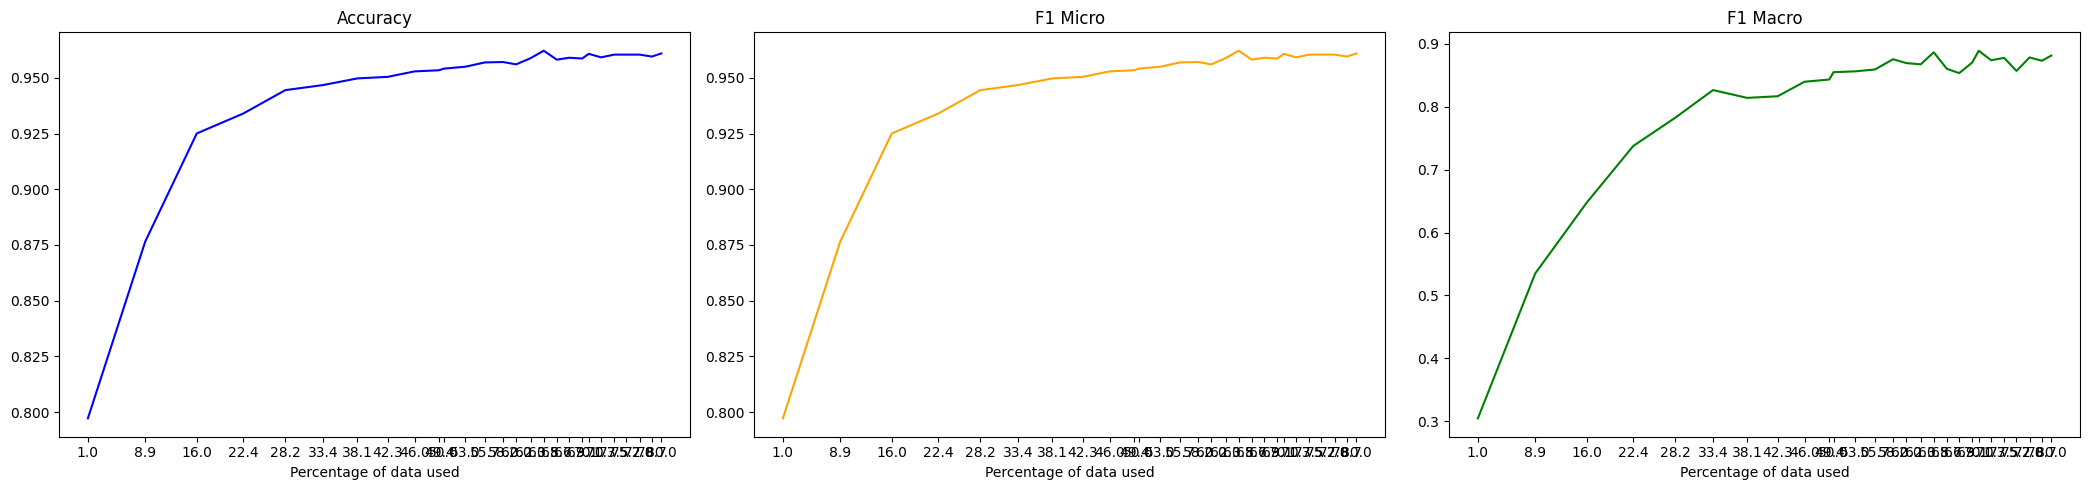

In [21]:
initial_train_size = int(0.01 * total_data)
active_learning(81, 0, 0.9, 1)

Init size: 10
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6304, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Epoch 2/10, Train Loss: 0.4839, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 3/10, Train Loss: 0.4418, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4257, Accuracy: 0.803, F1 Micro: 0.8905, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4169, Accuracy: 0.8304, F1 Micro: 0.9037, F1 Macro: 0.8985
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3785, Accuracy: 0.8505, F1 Micro: 0.9137, F1 Macro: 0.9087
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3439, Accuracy: 0.8767, F1 Micro: 0.9277, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3093, Accuracy: 0.8839, F1 Micro: 0.9316, F1 Macro: 0.9269
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.274, Accuracy: 0.9042, F1 Micro: 0.9423, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5629, Accuracy: 0.7088, F1 Micro: 0.7088, F1 Macro: 0.4148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3944, Accuracy: 0.7804, F1 Micro: 0.7804, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3384, Accuracy: 0.7995, F1 Micro: 0.7995, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2906, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.233, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7668
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2122, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1913, Accuracy: 0.8222, F1 Micro: 0.8222, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1635, Accuracy: 0.8305, F1 Micro: 0.8305, F1 Macro: 0.7737
Epoch 9/10, Train Loss: 0.1457, Accuracy: 0.8103, F1 Micro: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.559, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4548, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4344, Accuracy: 0.8085, F1 Micro: 0.8932, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3826, Accuracy: 0.8455, F1 Micro: 0.9107, F1 Macro: 0.9039
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.336, Accuracy: 0.8946, F1 Micro: 0.9369, F1 Macro: 0.9303
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.278, Accuracy: 0.9059, F1 Micro: 0.9436, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2426, Accuracy: 0.9236, F1 Micro: 0.9538, F1 Macro: 0.9503
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2052, Accuracy: 0.9295, F1 Micro: 0.9571, F1 Macro: 0.9541
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4938, Accuracy: 0.7397, F1 Micro: 0.7397, F1 Macro: 0.461
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3666, Accuracy: 0.8171, F1 Micro: 0.8171, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2637, Accuracy: 0.8295, F1 Micro: 0.8295, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2, Accuracy: 0.8378, F1 Micro: 0.8378, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1684, Accuracy: 0.8409, F1 Micro: 0.8409, F1 Macro: 0.7537
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1308, Accuracy: 0.8512, F1 Micro: 0.8512, F1 Macro: 0.7847
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1064, Accuracy: 0.8626, F1 Micro: 0.8626, F1 Macro: 0.7988
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.8564, F1 Micro: 0.8564, F1 Macro: 0.7838
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.8698, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5515, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4596, Accuracy: 0.8144, F1 Micro: 0.8955, F1 Macro: 0.8898
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4207, Accuracy: 0.8536, F1 Micro: 0.9144, F1 Macro: 0.9068
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3526, Accuracy: 0.8823, F1 Micro: 0.9311, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2818, Accuracy: 0.922, F1 Micro: 0.9528, F1 Macro: 0.9484
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2305, Accuracy: 0.9316, F1 Micro: 0.9582, F1 Macro: 0.9545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2109, Accuracy: 0.9375, F1 Micro: 0.9618, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1756, Accuracy: 0.942, F1 Micro: 0.9645, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4884, Accuracy: 0.791, F1 Micro: 0.791, F1 Macro: 0.6262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3471, Accuracy: 0.8391, F1 Micro: 0.8391, F1 Macro: 0.743
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2393, Accuracy: 0.8678, F1 Micro: 0.8678, F1 Macro: 0.8221
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1864, Accuracy: 0.8791, F1 Micro: 0.8791, F1 Macro: 0.8312
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1577, Accuracy: 0.8863, F1 Micro: 0.8863, F1 Macro: 0.8419
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.8945, F1 Micro: 0.8945, F1 Macro: 0.8575
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.8863, F1 Micro: 0.8863, F1 Macro: 0.846
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1242, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8659
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.9037, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5353, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4527, Accuracy: 0.8233, F1 Micro: 0.9002, F1 Macro: 0.8954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3741, Accuracy: 0.8892, F1 Micro: 0.9344, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2968, Accuracy: 0.9212, F1 Micro: 0.9526, F1 Macro: 0.949
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2364, Accuracy: 0.9295, F1 Micro: 0.9572, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2057, Accuracy: 0.9354, F1 Micro: 0.9608, F1 Macro: 0.9579
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.176, Accuracy: 0.9436, F1 Micro: 0.9655, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1598, Accuracy: 0.9446, F1 Micro: 0.966, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5008, Accuracy: 0.7996, F1 Micro: 0.7996, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3056, Accuracy: 0.8419, F1 Micro: 0.8419, F1 Macro: 0.7556
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2453, Accuracy: 0.8741, F1 Micro: 0.8741, F1 Macro: 0.8255
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1837, Accuracy: 0.8862, F1 Micro: 0.8862, F1 Macro: 0.8413
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.8842, F1 Micro: 0.8842, F1 Macro: 0.8319
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8553
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0822, Accuracy: 0.9003, F1 Micro: 0.9003, F1 Macro: 0.8626
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.8487
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8573
Epoch 10/10, Train Loss: 0.0404, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5362, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4428, Accuracy: 0.8505, F1 Micro: 0.9132, F1 Macro: 0.9063
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3507, Accuracy: 0.909, F1 Micro: 0.9451, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.26, Accuracy: 0.9328, F1 Micro: 0.9592, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2209, Accuracy: 0.9382, F1 Micro: 0.9623, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1869, Accuracy: 0.9458, F1 Micro: 0.9668, F1 Macro: 0.964
Epoch 7/10, Train Loss: 0.1626, Accuracy: 0.9436, F1 Micro: 0.9655, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1373, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1172, Accuracy: 0.954,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4613, Accuracy: 0.8014, F1 Micro: 0.8014, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3162, Accuracy: 0.8582, F1 Micro: 0.8582, F1 Macro: 0.7981
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.239, Accuracy: 0.8814, F1 Micro: 0.8814, F1 Macro: 0.8411
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.8872, F1 Micro: 0.8872, F1 Macro: 0.853
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1383, Accuracy: 0.8891, F1 Micro: 0.8891, F1 Macro: 0.8491
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8592
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8622
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0783, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8689
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.8968, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.529, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4369, Accuracy: 0.8738, F1 Micro: 0.9255, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3147, Accuracy: 0.9234, F1 Micro: 0.9536, F1 Macro: 0.9497
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2472, Accuracy: 0.9391, F1 Micro: 0.9626, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1996, Accuracy: 0.9439, F1 Micro: 0.9657, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.172, Accuracy: 0.949, F1 Micro: 0.9686, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1475, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9682
Epoch 8/10, Train Loss: 0.1298, Accuracy: 0.9491, F1 Micro: 0.9687, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1089, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4496, Accuracy: 0.8602, F1 Micro: 0.8602, F1 Macro: 0.8046
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3122, Accuracy: 0.8791, F1 Micro: 0.8791, F1 Macro: 0.8389
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2137, Accuracy: 0.8895, F1 Micro: 0.8895, F1 Macro: 0.8507
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.8924, F1 Micro: 0.8924, F1 Macro: 0.8532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.8531
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0792, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Macro: 0.8569
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0627, Accuracy: 0.8999, F1 Micro: 0.8999, F1 Macro: 0.8716
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.8999, F1 Micro: 0.8999, F1 Macro: 0.8692
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5245, Accuracy: 0.809, F1 Micro: 0.8928, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3999, Accuracy: 0.8974, F1 Micro: 0.9383, F1 Macro: 0.931
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.285, Accuracy: 0.9307, F1 Micro: 0.9579, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2183, Accuracy: 0.9391, F1 Micro: 0.9629, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.185, Accuracy: 0.9483, F1 Micro: 0.9682, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1579, Accuracy: 0.9512, F1 Micro: 0.9699, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1321, Accuracy: 0.9547, F1 Micro: 0.972, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1156, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.971
Epoch 9/10, Train Loss: 0.0983, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.45, Accuracy: 0.8427, F1 Micro: 0.8427, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2852, Accuracy: 0.8758, F1 Micro: 0.8758, F1 Macro: 0.8368
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1834, Accuracy: 0.8853, F1 Micro: 0.8853, F1 Macro: 0.8408
Epoch 4/10, Train Loss: 0.1196, Accuracy: 0.8825, F1 Micro: 0.8825, F1 Macro: 0.8357
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1062, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8754
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.891, F1 Micro: 0.891, F1 Macro: 0.8487
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.871
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8721
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8789
Epoch 10/10, Train Loss: 0.051, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5172, Accuracy: 0.8111, F1 Micro: 0.8924, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3861, Accuracy: 0.9052, F1 Micro: 0.943, F1 Macro: 0.9383
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2734, Accuracy: 0.9333, F1 Micro: 0.9592, F1 Macro: 0.9559
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2081, Accuracy: 0.9446, F1 Micro: 0.966, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1758, Accuracy: 0.9474, F1 Micro: 0.9677, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1484, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9698
Epoch 7/10, Train Loss: 0.1233, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9692
Epoch 8/10, Train Loss: 0.1046, Accuracy: 0.9547, F1 Micro: 0.972, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0932, Accuracy: 0.9556, F1 Micro: 0.9725, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3882, Accuracy: 0.8513, F1 Micro: 0.8513, F1 Macro: 0.7944
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2561, Accuracy: 0.879, F1 Micro: 0.879, F1 Macro: 0.8428
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1919, Accuracy: 0.8873, F1 Micro: 0.8873, F1 Macro: 0.8506
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1309, Accuracy: 0.891, F1 Micro: 0.891, F1 Macro: 0.8617
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1126, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8759
Epoch 6/10, Train Loss: 0.081, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0542, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8749
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.8947, F1 Micro: 0.8947, F1 Macro: 0.8583
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.8883, F1 Micro: 0.8883, F1 Macro: 0.8487
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5133, Accuracy: 0.8115, F1 Micro: 0.8945, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3742, Accuracy: 0.9108, F1 Micro: 0.9465, F1 Macro: 0.942
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2558, Accuracy: 0.9375, F1 Micro: 0.962, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2031, Accuracy: 0.9441, F1 Micro: 0.9659, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.164, Accuracy: 0.9528, F1 Micro: 0.9709, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.135, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1189, Accuracy: 0.9578, F1 Micro: 0.9738, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1028, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9731
Epoch 9/10, Train Loss: 0.0864, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3937, Accuracy: 0.8541, F1 Micro: 0.8541, F1 Macro: 0.8071
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2475, Accuracy: 0.882, F1 Micro: 0.882, F1 Macro: 0.8362
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1617, Accuracy: 0.895, F1 Micro: 0.895, F1 Macro: 0.8587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1227, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.862
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0912, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8648
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8627
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0614, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8741
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8735
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.8613
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5057, Accuracy: 0.8144, F1 Micro: 0.8959, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3727, Accuracy: 0.9116, F1 Micro: 0.9467, F1 Macro: 0.9413
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2557, Accuracy: 0.9328, F1 Micro: 0.9591, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1994, Accuracy: 0.9481, F1 Micro: 0.9681, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1643, Accuracy: 0.9538, F1 Micro: 0.9715, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.118, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1013, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9727
Epoch 9/10, Train Loss: 0.0883, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4353, Accuracy: 0.8568, F1 Micro: 0.8568, F1 Macro: 0.8131
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2546, Accuracy: 0.8867, F1 Micro: 0.8867, F1 Macro: 0.852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1651, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8628
Epoch 4/10, Train Loss: 0.1473, Accuracy: 0.8894, F1 Micro: 0.8894, F1 Macro: 0.854
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0924, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0703, Accuracy: 0.9003, F1 Micro: 0.9003, F1 Macro: 0.8696
Epoch 7/10, Train Loss: 0.0507, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.8667
Epoch 8/10, Train Loss: 0.0375, Accuracy: 0.8921, F1 Micro: 0.8921, F1 Macro: 0.8597
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.874
Epoch 10/10, Train Loss: 0.044, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5082, Accuracy: 0.8188, F1 Micro: 0.8976, F1 Macro: 0.8916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3556, Accuracy: 0.9194, F1 Micro: 0.9512, F1 Macro: 0.947
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2442, Accuracy: 0.9427, F1 Micro: 0.965, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1936, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1628, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1284, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9717
Epoch 7/10, Train Loss: 0.1153, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0969, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9731
Epoch 9/10, Train Loss: 0.0828, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3873, Accuracy: 0.8552, F1 Micro: 0.8552, F1 Macro: 0.8023
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2424, Accuracy: 0.883, F1 Micro: 0.883, F1 Macro: 0.8419
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1727, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8771
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1196, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1055, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0738, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8852
Epoch 7/10, Train Loss: 0.0631, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8693
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0486, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.8852
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8833
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4952, Accuracy: 0.8281, F1 Micro: 0.9027, F1 Macro: 0.8977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3477, Accuracy: 0.9149, F1 Micro: 0.949, F1 Macro: 0.9454
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2403, Accuracy: 0.9444, F1 Micro: 0.966, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1901, Accuracy: 0.9484, F1 Micro: 0.9683, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.9536, F1 Micro: 0.9713, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1097, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9735
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0811, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3899, Accuracy: 0.8599, F1 Micro: 0.8599, F1 Macro: 0.8209
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2421, Accuracy: 0.8915, F1 Micro: 0.8915, F1 Macro: 0.8587
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1707, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.8548
Epoch 4/10, Train Loss: 0.1216, Accuracy: 0.8924, F1 Micro: 0.8924, F1 Macro: 0.8534
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0894, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8678
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0575, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.047, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8842
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8709
Epoch 10/10, Train Loss: 0.0241, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5003, Accuracy: 0.8335, F1 Micro: 0.9046, F1 Macro: 0.8977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3333, Accuracy: 0.9259, F1 Micro: 0.9548, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.232, Accuracy: 0.9448, F1 Micro: 0.9662, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1872, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1295, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1092, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.397, Accuracy: 0.8459, F1 Micro: 0.8459, F1 Macro: 0.7862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2347, Accuracy: 0.8806, F1 Micro: 0.8806, F1 Macro: 0.848
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1667, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1104, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0768, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8758
Epoch 6/10, Train Loss: 0.0633, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8674
Epoch 7/10, Train Loss: 0.0549, Accuracy: 0.9034, F1 Micro: 0.9034, F1 Macro: 0.8708
Epoch 8/10, Train Loss: 0.0416, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8756
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8674
Epoch 10/10, Train Loss: 0.0247, Accuracy: 0.9034, F1 Micro: 0.9034, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4882, Accuracy: 0.838, F1 Micro: 0.9069, F1 Macro: 0.9001
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3192, Accuracy: 0.9255, F1 Micro: 0.9548, F1 Macro: 0.9515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2287, Accuracy: 0.941, F1 Micro: 0.964, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1833, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1425, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9712
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4053, Accuracy: 0.8564, F1 Micro: 0.8564, F1 Macro: 0.799
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2231, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8685
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.15, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1119, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8779
Epoch 5/10, Train Loss: 0.0822, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0638, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0591, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.885
Epoch 8/10, Train Loss: 0.0249, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8725
Epoch 9/10, Train Loss: 0.0218, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8799
Epoch 10/10, Train Loss: 0.0224, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4886, Accuracy: 0.845, F1 Micro: 0.9098, F1 Macro: 0.901
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3157, Accuracy: 0.9238, F1 Micro: 0.954, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2166, Accuracy: 0.9413, F1 Micro: 0.964, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1024, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0743, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3674, Accuracy: 0.8683, F1 Micro: 0.8683, F1 Macro: 0.8257
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2369, Accuracy: 0.8895, F1 Micro: 0.8895, F1 Macro: 0.8503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1788, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1048, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.884
Epoch 5/10, Train Loss: 0.0809, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0623, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.8898
Epoch 7/10, Train Loss: 0.0554, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8718
Epoch 8/10, Train Loss: 0.0399, Accuracy: 0.895, F1 Micro: 0.895, F1 Macro: 0.8566
Epoch 9/10, Train Loss: 0.0306, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8858
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4869, Accuracy: 0.8413, F1 Micro: 0.9094, F1 Macro: 0.9045
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3172, Accuracy: 0.9335, F1 Micro: 0.9596, F1 Macro: 0.9567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2143, Accuracy: 0.9441, F1 Micro: 0.9659, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9498, F1 Micro: 0.969, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.144, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1153, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0993, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9732
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0705, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3565, Accuracy: 0.8617, F1 Micro: 0.8617, F1 Macro: 0.8117
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2199, Accuracy: 0.8947, F1 Micro: 0.8947, F1 Macro: 0.8643
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.162, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8824
Epoch 4/10, Train Loss: 0.1076, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8768
Epoch 5/10, Train Loss: 0.0722, Accuracy: 0.9075, F1 Micro: 0.9075, F1 Macro: 0.8831
Epoch 6/10, Train Loss: 0.0657, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8779
Epoch 7/10, Train Loss: 0.0583, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.8759
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.034, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8882
Epoch 10/10, Train Loss: 0.0182, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8805

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4744, Accuracy: 0.8602, F1 Micro: 0.9189, F1 Macro: 0.9131
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3054, Accuracy: 0.93, F1 Micro: 0.9573, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2105, Accuracy: 0.9462, F1 Micro: 0.9671, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9741
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9737
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3558, Accuracy: 0.8833, F1 Micro: 0.8833, F1 Macro: 0.8448
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1989, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8725
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1563, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8882
Epoch 4/10, Train Loss: 0.1121, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0882, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8894
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0569, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.8955
Epoch 7/10, Train Loss: 0.0385, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0298, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.896
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.9185, F1 Micro: 0.9185, F1 Macro: 0.8929
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4709, Accuracy: 0.8682, F1 Micro: 0.9221, F1 Macro: 0.9121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2875, Accuracy: 0.9347, F1 Micro: 0.9602, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.9474, F1 Micro: 0.9677, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.164, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0766, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.368, Accuracy: 0.8659, F1 Micro: 0.8659, F1 Macro: 0.8183
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2152, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8759
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1458, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8756
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1037, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0803, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8835
Epoch 6/10, Train Loss: 0.0566, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8825
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0453, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0391, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8854
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8836
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4716, Accuracy: 0.8635, F1 Micro: 0.9208, F1 Macro: 0.916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2906, Accuracy: 0.9318, F1 Micro: 0.9583, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2041, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0774, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3497, Accuracy: 0.8718, F1 Micro: 0.8718, F1 Macro: 0.828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.205, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1313, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8889
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0979, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8895
Epoch 5/10, Train Loss: 0.0684, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0622, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8941
Epoch 7/10, Train Loss: 0.0443, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.8934
Epoch 8/10, Train Loss: 0.0389, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.8951
Epoch 9/10, Train Loss: 0.0285, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.8927
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0165, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4732, Accuracy: 0.8755, F1 Micro: 0.9264, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2926, Accuracy: 0.9307, F1 Micro: 0.9579, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2036, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1598, Accuracy: 0.9507, F1 Micro: 0.9696, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.113, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3691, Accuracy: 0.8416, F1 Micro: 0.8416, F1 Macro: 0.7754
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2038, Accuracy: 0.8842, F1 Micro: 0.8842, F1 Macro: 0.8476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1414, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1135, Accuracy: 0.8986, F1 Micro: 0.8986, F1 Macro: 0.8679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0714, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8762
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0678, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8762
Epoch 7/10, Train Loss: 0.0446, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.8673
Epoch 8/10, Train Loss: 0.0366, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8732
Epoch 9/10, Train Loss: 0.0279, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.872
Epoch 10/10, Train Loss: 0.03, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4597, Accuracy: 0.8762, F1 Micro: 0.927, F1 Macro: 0.9207
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2832, Accuracy: 0.9392, F1 Micro: 0.9628, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1983, Accuracy: 0.9432, F1 Micro: 0.9654, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1607, Accuracy: 0.9505, F1 Micro: 0.9697, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1333, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1102, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9761
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9742
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9755
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3889, Accuracy: 0.8553, F1 Micro: 0.8553, F1 Macro: 0.8068
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2184, Accuracy: 0.8841, F1 Micro: 0.8841, F1 Macro: 0.8441
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.16, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.8632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1347, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8665
Epoch 5/10, Train Loss: 0.0974, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8596
Epoch 6/10, Train Loss: 0.0644, Accuracy: 0.8931, F1 Micro: 0.8931, F1 Macro: 0.8605
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0586, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8718
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.8967, F1 Micro: 0.8967, F1 Macro: 0.8658
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.874
Epoch 10/10, Train Loss: 0.0297, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4691, Accuracy: 0.8776, F1 Micro: 0.9279, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2827, Accuracy: 0.9347, F1 Micro: 0.9605, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1965, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1052, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9759
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9728
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0659, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3291, Accuracy: 0.863, F1 Micro: 0.863, F1 Macro: 0.8052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2224, Accuracy: 0.8944, F1 Micro: 0.8944, F1 Macro: 0.8552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1371, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8742
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0961, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0844, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0563, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.8945
Epoch 7/10, Train Loss: 0.0401, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.89
Epoch 8/10, Train Loss: 0.043, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.882
Epoch 9/10, Train Loss: 0.0297, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.8897
Epoch 10/10, Train Loss: 0.0241, Accuracy: 0.9046

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4589, Accuracy: 0.883, F1 Micro: 0.9302, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.271, Accuracy: 0.9365, F1 Micro: 0.9613, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.152, Accuracy: 0.9545, F1 Micro: 0.9719, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.9611, F1 Micro: 0.9758, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.9644, F1 Micro: 0.9778, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3587, Accuracy: 0.8502, F1 Micro: 0.8502, F1 Macro: 0.7952
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2158, Accuracy: 0.8843, F1 Micro: 0.8843, F1 Macro: 0.8438
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1528, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1072, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0887, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8743
Epoch 6/10, Train Loss: 0.0536, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8736
Epoch 7/10, Train Loss: 0.0534, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8711
Epoch 8/10, Train Loss: 0.0447, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8717
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8735
Epoch 10/10, Train Loss: 0.0371, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4568, Accuracy: 0.8773, F1 Micro: 0.9274, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2728, Accuracy: 0.9345, F1 Micro: 0.9603, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9755
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.9665, F1 Micro: 0.9792, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3587, Accuracy: 0.8738, F1 Micro: 0.8738, F1 Macro: 0.8407
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2107, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8674
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1242, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8901
Epoch 4/10, Train Loss: 0.0932, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8863
Epoch 5/10, Train Loss: 0.062, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8866
Epoch 6/10, Train Loss: 0.0474, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8822
Epoch 7/10, Train Loss: 0.0367, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0295, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.889
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8686
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0274, Accuracy: 0.9152, F1 Micro: 0.9152, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4528, Accuracy: 0.8839, F1 Micro: 0.9315, F1 Macro: 0.9268
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2678, Accuracy: 0.9405, F1 Micro: 0.9636, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1864, Accuracy: 0.9505, F1 Micro: 0.9697, F1 Macro: 0.9678
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.9434, F1 Micro: 0.9655, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0843, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0608, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3287, Accuracy: 0.8672, F1 Micro: 0.8672, F1 Macro: 0.8144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1799, Accuracy: 0.8921, F1 Micro: 0.8921, F1 Macro: 0.858
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1287, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8776
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0995, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0637, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.8989
Epoch 6/10, Train Loss: 0.0653, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.8901
Epoch 7/10, Train Loss: 0.0412, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.8959
Epoch 8/10, Train Loss: 0.0269, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.8968
Epoch 9/10, Train Loss: 0.0238, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.8937
Epoch 10/10, Train Loss: 0.0266, Accuracy: 0.917, F1 Micro: 0.917, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4447, Accuracy: 0.8842, F1 Micro: 0.9315, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2635, Accuracy: 0.9392, F1 Micro: 0.963, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1832, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9762
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0684, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9646, F1 Micro: 0.978, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3462, Accuracy: 0.8776, F1 Micro: 0.8776, F1 Macro: 0.8373
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1943, Accuracy: 0.8895, F1 Micro: 0.8895, F1 Macro: 0.8507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1257, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0973, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0667, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8875
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0644, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.05, Accuracy: 0.9187, F1 Micro: 0.9187, F1 Macro: 0.8953
Epoch 8/10, Train Loss: 0.039, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.8872
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8912
Epoch 10

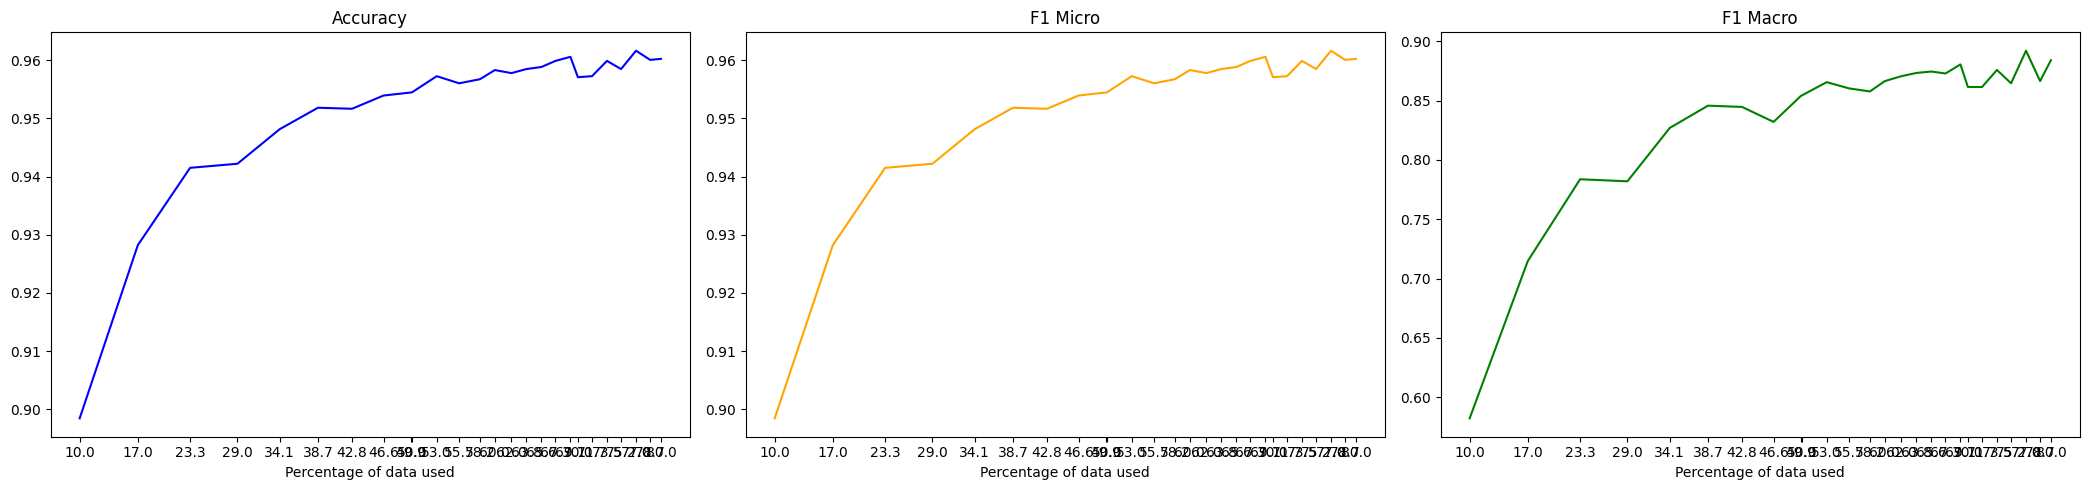

In [ ]:
initial_train_size = int(0.1 * total_data)
active_learning(81, 0, 0.9, 10)